In this part of the exercise, you will build a logistic regression model to predict
whether a student gets admitted into a university.
Suppose that you are the administrator of a university department and you
want to determine each applicant’s chance of admission based on their results on
two exams. You have historical data from previous applicants that you can use
as a training set for logistic regression. For each training example, you have the
applicant’s scores on two exams and the admissions decision. Your task is to build a
classication model that estimates an applicant’s probability of admission based the
scores from those two exams.

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from pylab import *
from scipy.optimize import fmin

# Part 1 : simple logistic regression

### Load data

In [2]:
df = pd.read_csv('data/ex3data1.csv')
df.head()

,feature1,feature2,label
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


### Visualize data

In [3]:
def plot_classes(X,y):
    pos = np.where(y == 1)
    neg = np.where(y == 0)
    plt.scatter(X[pos, 0], X[pos, 1], marker='o', c='b')
    plt.scatter(X[neg, 0], X[neg, 1], marker='x', c='r')
    plt.xlabel('feature 1')
    plt.ylabel('feature 2')
    plt.legend(['positive', 'negative'])
    plt.show()
    

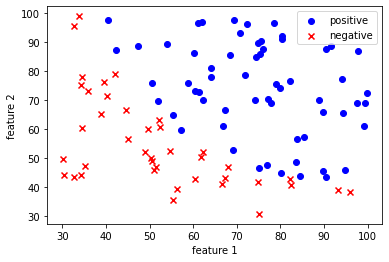

In [4]:
plot_classes(df[['feature1','feature2']].values,df['label'].values)

### normalize input

In [5]:
# ** normalize and standardize are used interchangably in our course
# As you can see features are in different scales

def feature_normalize(X,mu=None,sigma=None):
    if(mu is not None and sigma is not None):
        X_norm = (X - mu) / sigma
        return X_norm
    
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    X_norm = (X - mu) / sigma  #(new feature value = (old feature value - mean) / standard deviation)
    return X_norm, mu, sigma

### initialize variables

In [6]:
X = df[['feature1','feature2']].values
y = df['label'].values.reshape(-1,1)
X = feature_normalize(X)[0]

[m, n] = X.shape
# Add intercept term to x and X_test
X = np.hstack((np.ones((m, 1)), X))
# Initialize fitting parameters
initial_theta = np.zeros((n + 1, 1))

### find optimized theta with sklearn implentation of logistic regression

In [7]:
# train scikit learn model 
clf = LogisticRegression()
clf.fit(X,y)

print('Scikit learn theta: ',clf.coef_)
print ('accuracy on train data: ', clf.score(X,y))

#print ('theta:', theta)
#print ('cost:', cost_function_gradient(X,y,theta)[0])

Scikit learn theta:  [[-4.53827015e-05  2.28990038e+00  2.09603840e+00]]
accuracy on train data:  0.89


E:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### optimization functions

check sigmoid function from [here](https://www.google.com/search?sxsrf=ALeKk02Bo3eOu0KeGoWSMbwlbUaEFnKImA%3A1588402850379&ei=ohqtXsLZFpKMrwSwgbGwDQ&q=1%2F%281%2Bexp%28-x%29%29&oq=1%2F%281%2Bexp&gs_lcp=CgZwc3ktyWIQAxgAMgcIABAUEIcCMgIIADIECAAQHjIECAAQHjIHCAAQFBCHAjICCAAyBggAEAUQHjIGCAAQCBAeMgyIABAIEB4yBggAEAgQHjoECAAQRzoECCMQJzoFCAAQkQJQxqgBWMPoAWCb8wFoAnAEeACAAf8BiAH6EZIBBDItMTCyAQCgAQGqAQdnd3Mtd2l6&sclient=psy-ab)

Warmup exercise: sigmoid function Before you start with the actual cost func-
tion, recall that the logistic regression hypothesis is defined as:
$$ h_\theta (x) = g(\theta^Tx) $$
where function g is the sigmoid function. The sigmoid function is defined as:
$$ g(z) = \frac{1}{1+e^{-z}} $$ 

In [8]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

In [9]:
def hypothesis(X,theta):
    # 1.calculate linear combination of weigths and features. try to use matrix operations instead of loop
    # 2.calculate sigmoid of linear combination to convert it to probability
    return  sigmoid(np.dot(X,theta))

When you are finished, try testing a few values by calling
sigmoid(x). For large positive values of x, the sigmoid should be close to 1, while
for large negative values, the sigmoid should be close to 0. Evaluating sigmoid(0)
should give you exactly 0.5. Your code should also work with vectors and matrices.
For a matrix, your function should perform the sigmoid function on every element.

Now you will implement the cost function and gradient for logistic regression.

![gradient](img/gradient.png)

In [10]:
def cost_function_gradient(X,y,theta):
    # Compute the cost of a particular choice of theta.
    # you should set J to the cost.
    J = 0
    m = len(y) # number of training examples
    for i in range(m):
        if y[i] == 1:
            J = J + (-np.log(hypothesis(X,theta)[i]))
        elif y[i] == 0:
            J = J + (-np.log(1-(hypothesis(X,theta)[i])))
            
    J = J/m 
    # TODO : write the cost function without loop and without if else condition in one line of code
    h = hypothesis(X,theta);
    J = ((- y.T@np.log(h)) - ((1-y).T@np.log(1-h)))/m
    # compute the partial derivatives and set grad to the partial
    # derivatives of the cost w.r.t. each parameter in theta
    # Note: grad should have the same dimensions as theta
    # you can check it from page 18 of cs299-notes1.pdf 
    grad = (y-h).T@X /m
    
    return [J[0][0],grad.T]

Note that while this gradient looks identical to the linear regression gradient, the
formula is actually different because linear and logistic regression have different
definitions of $$ h_\theta (x) $$

![simple optimize](img/optimize1.png)

In [11]:
def optimize(X,y,theta,number_of_iterations,alpha):
    # 1. compute gradient for for the theta ( use cost_function_gradient function )
    # 2. update theta: theta = theta + alpha*gradient  
    # 3. append new cost and theta to list
    # 4. go to 1 
    # you can check it from page 7 of cs299-notes1.pdf  
    # TODO
    theta_history = []
    cost_history = []
    for i in range (number_of_iterations):
        cost,grad=cost_function_gradient(X,y,theta)
        theta = theta + (alpha * grad)
        theta_history.append(theta)
        cost_history.append(cost)
    return [cost_history,theta_history]

In [12]:
def accuracy(p,y):
     return np.mean(p==y)

### run optimization

In [13]:
number_of_iterations = 400
#alpha = 0.01
alpha = 1
cost_history,theta_history = optimize(X,y,initial_theta,number_of_iterations,alpha)

theta = theta_history[-1]

In [14]:
cost_function_gradient(X,y,theta)

[0.2036038039940683,
 array([[0.00036128],
        [0.00077374],
        [0.00074854]])]

In [15]:
accuracy(y,hypothesis(X,theta)>0.5)

0.89

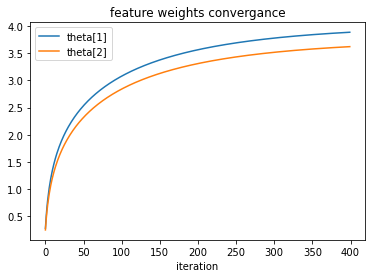

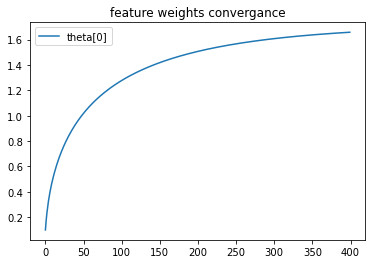

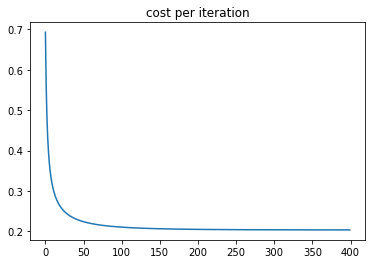

In [16]:
theta_history_ = [theta_history[i][1:].ravel() for i in range(len(theta_history))]
plt.plot(np.array(theta_history_)[:,0])
plt.plot(np.array(theta_history_)[:,1])
plt.xlabel('iteration')
plt.legend(['theta[1]','theta[2]'])
plt.title('feature weights convergance')
plt.show()

theta_history_ = [theta_history[i][0].ravel() for i in range(len(theta_history))]
plt.plot(np.array(theta_history_))
plt.legend(['theta[0]'])
plt.title('feature weights convergance')

plt.show()

plt.plot(cost_history)
plt.title('cost per iteration')
plt.show()

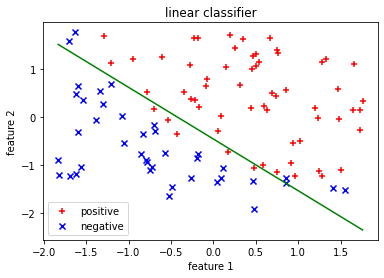

In [17]:
pos , neg = (y==1).reshape(100,1) , (y==0).reshape(100,1)
plt.scatter(X[pos[:,0],1],X[pos[:,0],2],c="r",marker="+",label="positive")
plt.scatter(X[neg[:,0],1],X[neg[:,0],2],c="b",marker="x",label="negative")
x_value= np.array([np.min(X[:,1]),np.max(X[:,1])])
y_value=-(theta[0] +theta[1]*x_value)/theta[2]
plt.plot(x_value,y_value, "g")
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(loc=0)
plt.title('linear classifier')
plt.show()

TODO:
1. comment X = feature_normalize(X)[0] in  initialize variables cell
2. set alpha =.01 or less
3. run part cells again
4. compare "feature weigths convergance" and "cost per iteration" plots with the previous round.
5. explain what happended? how feature_normalize is helping the convergance ? 

<div style="direction:rtl">
با توجه به اینکه آلفا در وافع همون طول گام یا ریت یادگیری ما است پس طبیعی است هر چه آن را کم کنیم باید همگراهی نمودار ها با شیب کم تری صورت گیرد. و هر چه آن را کوچک تر کنیم چون عملیات تکراری زیاد تر میشود این شیب کم تر میشود و با سرعت کم تری  در زمینه ی کاست کاهش میابد. اگر الفا ۰.۰۱ با ۱ مقایسه کنیم شاید شیب کم تر در کاست در زمان کاهش آن خستیم و با سرعت کم تری کاهش میابد و به عدد بزرگ تری به نسبت آلفا ۱ میل میکند که ۰.۴ است. در صورتی که در آلفای یک با سرعت بیشتر و شیب بیشتری به سمت ۰.۲میل میکرد. در خصوص همگرایی تتا هم به همین شکل که همگرایی آن در مقدار بالا تری صورت میگیرد. 
</div>
<div style="direction:rtl">
  از آنجایی که در دنیای واقعی احتمال دارد ورودی های مختلف ما بسیار از هم دور باشند بنابراین نیاز داریم کمی آن ها را به هم نزدیک تر کنیم تا نوسانات تغییرات را در زمان محاسبات کاهش دهیم، همچنین در زمانی که نورمالایز نکنیم خروجی از accuracy بسیار پایین تری برخوردار است زیرا به علت دور بودن داده ها از هم انجام عملیات بر روی آنها بسیار دشوار میشود. این جریان در خصوص همگرایی نیز همینگونه است. که در صورتی که نورمالایز نکنیم به علت نوسانات تغییرات بالا در زمان محاسبات مشاهده ی همگرایی نمودار ها ممکن نمیشود و رصد کردن تغییرات بسیار مشکل است.
</div>

In [18]:
x = np.array([1, 0.1, -0.5]).reshape(1,3)
prob = hypothesis(x, theta)
print ('For new data point probability of being positive = ', prob)

For new data point probability of being positive =  [[0.55900773]]


# Part 2 : logistic regression with non linear input

In this part of the exercise, you will implement regularized logistic regression to
predict whether microchips from a fabrication plant passes quality assurance (QA).
During QA, each microchip goes through various tests to ensure it is functioning
correctly. Suppose you are the product manager of the factory and you have the
test results for some microchips on two different tests. From these two tests, you
would like to determine whether the microchips should be accepted or rejected. To
help you make the decision, you have a dataset of test results on past microchips,
from which you can build a logistic regression model

### Load data

In [19]:
df = pd.read_csv('data/ex3data2.csv')
df.head()

,feature1,feature2,label
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


### Visualize data

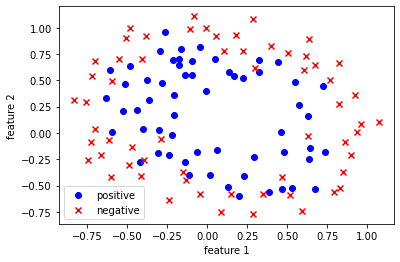

In [20]:
plot_classes(df[['feature1','feature2']].values,df['label'].values)

It is obvious that our dataset cannot be separated into positive and negative examples by a straight-line through the plot. Therefore, a straight- forward application of logistic regression will not perform well on this dataset since logistic regression will only be able to draw a linear decision boundary.

### initialize variables

In [21]:
X = df[['feature1','feature2']].values
y = df['label'].values.reshape(-1,1)


### find optimized theta with sklearn implentation of logistic regression

In [22]:
# train scikit learn model 
clf = LogisticRegression()
clf.fit(X,y)

print('Scikit learn theta: ',clf.coef_)
print ('accuracy on train data: ', clf.score(X,y))

Scikit learn theta:  [[-0.26541433 -0.01162176]]
accuracy on train data:  0.5423728813559322


E:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


accuracy is 0.54 for sklearn classifier whihch proves data is not linearly separable.

### non linear features

One way separate the data better is to create more features from each data point. In the provided function feature_map, we will map the features into all polynomial terms of x1 and x2 up to the degree power.

feature_map(x,6) = $$ \begin{bmatrix} 1 \\ x \\ x_1 \\ x_2 \\ x_1*x_2 \\ x_1^2 \\ x_2^2 \\ . \\ . \\ . \\ x_1*x_2^5 \\ x_2^6\end{bmatrix} $$

As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. A logistic regression classier trained on this higher-dimension feature vector will have a more complex decision boundary and will appear nonlinear when drawn in our 2-dimensional plot.
While the feature mapping allows us to build a more expressive classier, it also more susceptible to overfitting. In the next parts of the exercise, you will implement regularized logistic regression to fit the data and also see for yourself how regularization can help combat the overfitting problem.

In [23]:
def feature_map(X1, X2,degree):
    #  Feature mapping function to polynomial features
    #
    #   feature_mapping(X1, X2) maps the two input features
    #   to quadratic features used in the regularization exercise.
    #
    #   Returns a new feature array with more features, comprising of
    #   X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    #
    #   Inputs X1, X2 must be the same size
    #
    # TODO

    X1 = X1.reshape((X1.size, 1))
    X2 = X2.reshape((X2.size, 1))
    out = np.ones(X1[:, 0].shape)

    for i in range(1, degree + 1):
        for j in range(0, i + 1):
            out = np.c_[out, (X1**(i-j)) * (X2**j)]

    return out

In [24]:
X = feature_map(X[:, [0]], X[:, [1]],6)

#data was almost zero centered and features were are on the same scale,
# however polynomial features would have different scales, so we should normalize them.
#X[:,1:] = feature_normalize(X[:,1:])[0] # **** intercept doesnt need to be normalized as it is constant and its std is zero


### run optimization

In [25]:
number_of_iterations = 800
alpha = 0.1
initial_theta = np.zeros((X.shape[1],1))

cost_history,theta_history = optimize(X,y,initial_theta,number_of_iterations,alpha)
theta = theta_history[-1]

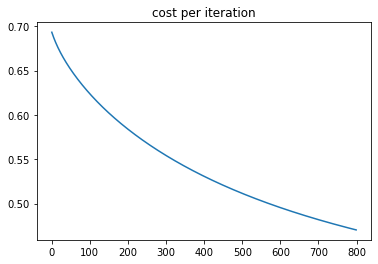

In [26]:
plt.plot(cost_history)
plt.title('cost per iteration')
plt.show()

TODO: Increase alpha to 1 but keep number_of_iterations = 800 and compare the cost

In [27]:
def feature_map_plot(x1,x2,degree):
    """
    take in numpy array of x1 and x2, return all polynomial terms up to the given degree
    """
    out = np.ones(1)
    for i in range(1,degree+1):
        for j in range(i+1):
            terms= (x1**(i-j) * x2**j)
            out= np.hstack((out,terms))
    return out

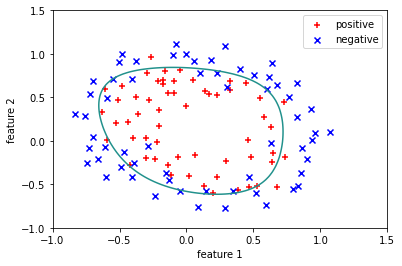

In [28]:
pos , neg = (y==1).reshape(118,1) , (y==0).reshape(118,1)
plt.scatter(X[pos[:,0],1],X[pos[:,0],2],c="r",marker="+",label="positive")
plt.scatter(X[neg[:,0],1],X[neg[:,0],2],c="b",marker="x",label="negative")

# Plotting decision boundary

u_vals = np.linspace(-1,1.5,100)
v_vals= np.linspace(-1,1.5,100)
z=np.zeros((len(u_vals),len(v_vals)))
for i in range(len(u_vals)):
    for j in range(len(v_vals)):
        z[i,j] =feature_map_plot(u_vals[i],v_vals[j],6) @ theta 

plt.contour(u_vals,v_vals,z.T,0)
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(loc=0)
plt.show()

#### in this part border is not correctly shown with normalization, please comment the X[:,1:] = feature_normalize(X[:,1:])[0] line and run part two once again to be able to see the border.

# Part 3 : Logistic regression with non linear features and l1 and l2 regularization

### Load data

In [29]:
df_train = pd.read_csv('data/Syndata-train.csv')
df_test = pd.read_csv('data/Syndata-test.csv')

### Visualize data

training data


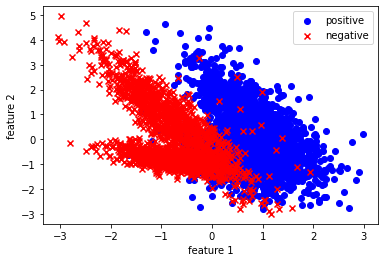

test data


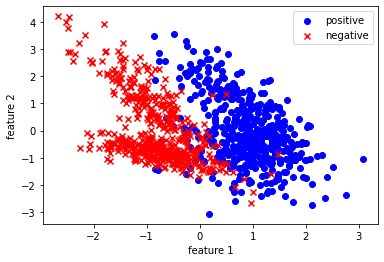

In [30]:
print('training data')
plot_classes(df_train[['feature1','feature2']].values,df_train['label'].values)
print('test data')
plot_classes(df_test[['feature1','feature2']].values,df_test['label'].values)

Again it is obvious that our dataset is not linearly separable. So we use feature_map once again to create polynomial features.

### initialize variables

In [31]:
X = df_train[['feature1','feature2']].values
y = df_train['label'].values.reshape(-1,1)

#degree = 6
degree = 4
# non linear features
X = feature_map(X[:, [0]], X[:, [1]],degree)

X[:,1:] = feature_normalize(X[:,1:])[0] # **** intercept doesnt need to be normalized as it is constant and its std is zero

X_train = X
y_train = y


X = df_test[['feature1','feature2']].values
y = df_test['label'].values.reshape(-1,1)

# non linear features
X = feature_map(X[:, [0]], X[:, [1]],degree)
X[:,1:] = feature_normalize(X[:,1:])[0] # **** intercept doesnt need to be normalized as it is constant and its std is zero


X_test = X
y_test = y


Now you will implement code to compute the cost function and gradient for regularized logistic regression. Recall that the regularized cost function in logistic regression is 
![gradient](img/l2.png)
Note that you should not regularize the parameter 0; thus, the final summation above is for j = 1 to n, not j = 0 to n. The gradient of the cost function is a vector where the j th element is defined as follows:
![gradient](img/l2_grad.png)

### Theoretical question : 
write down cost function and gradient of cost function for l1 norm. 
hint: $ \frac{\partial |\theta|}{\partial \theta} = sign(\theta) $


In [32]:
def cost_function_gradient_regularized(X,y,theta,lamda,norm_function):
    
    #TODO
    # copy ur code from cost_function_gradient
    J = 0
    m = len(y) # number of training examples
    # TODO : write the cost function without loop and without if else condition in one line of code
    h = hypothesis(X,theta);
    J = (-(( y.T@np.log(h)) + ((1-y).T@np.log(1-h)))/m)
    # compute the partial derivatives and set grad to the partial
    # derivatives of the cost w.r.t. each parameter in theta
    # Note: grad should have the same dimensions as theta
    # you can check it from page 18 of cs299-notes1.pdf 
    grad = ((y-h).T@X /m).T
    #TODO 
    if(norm_function == 'l2'):
        grad[1:] += 0 # grad[0] is intercept which is NOT regularized,
        J += 0
    elif(norm_function == 'l1'):
        grad[1:] +=lamda*theta[1:]/m  # grad[0] is intercept which is NOT regularized
        J +=  (lamda/m)*(theta[1:].T@theta[1:])
        #J +=  (lamda/2*m)*(theta[1:].T@theta[1:]) # If we divide by 2m, the cost will increase!
  
    return [J[0][0],grad]

In [33]:
# use cost_function_gradient_regularized for optimization
def optimize_regularized(X,y,theta,number_of_iterations,alpha,norm_function,lambda_):
    # 1. compute gradient for for the theta
    # 2. update theta: theta = theta + alpha*gradient  
    # 3. append new cost to list
    # 4. go to 1 
    # TODO
    cost_history = []
    for i in range (number_of_iterations):
        cost,grad=cost_function_gradient_regularized(X,y,theta,lambda_,norm_function)
        theta = theta + (alpha * grad)
        cost_history.append(cost)
        
    return [cost_history,theta]

### run optimization

In [34]:
number_of_iterations = 800
alpha = 0.01
lambda_ =0.1
norm_function = 'l1'
initial_theta = np.zeros((X.shape[1],1))
cost_history,theta = optimize_regularized(X_train,y_train,initial_theta,number_of_iterations,alpha,norm_function,lambda_)

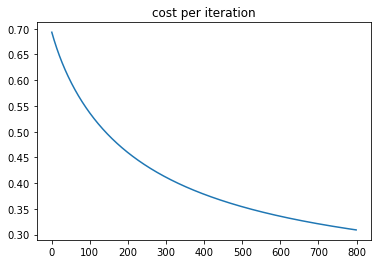

In [35]:
plt.plot(cost_history)
plt.title('cost per iteration')
plt.show()

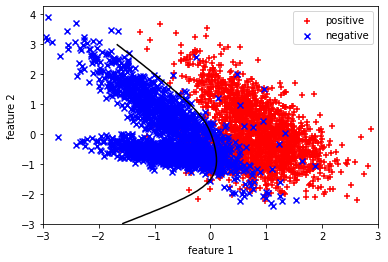

In [36]:
pos , neg = (y_train==1), (y_train==0)
plt.scatter(X_train[pos[:,0],1],X_train[pos[:,0],2],c="r",marker="+",label="positive")
plt.scatter(X_train[neg[:,0],1],X_train[neg[:,0],2],c="b",marker="x",label="negative")

# Plotting decision boundary

u_vals = np.linspace(-3,3,50)
v_vals= np.linspace(-3,3,50)

      
z=np.zeros((len(u_vals),len(v_vals)))
for i in range(len(u_vals)):
    for j in range(len(v_vals)):
        z[i,j] =feature_map_plot(u_vals[i],v_vals[j],degree) @ theta 

plt.contour(u_vals,v_vals,z.T,0,colors='black')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.legend(loc=0)

#TODO

1. plot cost_history for train data verus test data on the same plot
2. check accuracy of train data and test data for lambda = 0, 0.01, 0.1, 10
3. increase the degree of polynomial and check whether you have to increase or decrease lambda. explain why this happens
3. find a good regularization norm function and lambda for degree = 6

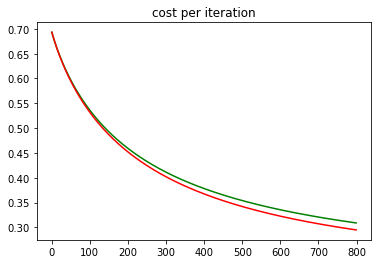

In [37]:
cost_history_2,theta_2 = optimize_regularized(X_test,y_test,initial_theta,number_of_iterations,alpha,norm_function,lambda_)
plt.plot(cost_history,"g")
plt.plot(cost_history_2,"r")
plt.title('cost per iteration')
plt.show()

In [38]:
print(accuracy(y_train,hypothesis(X_train,theta)>0.5))
print(accuracy(y_test,hypothesis(X_test,theta_2)>0.5))

0.92275
0.936
